In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import date2num , DateFormatter
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


from src.globals import raw_data_dir, interim_data_dir
from src.visualization import plot_metrics

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [4]:
# check GPU visibility
tf.config.get_visible_devices(
    device_type='GPU'
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
# load meteo files and concat into one df
dfs = []

for file_ in [f'meteo-20{i}.csv' for i in range(16,20)]:
    df = pd.read_csv(raw_data_dir/file_, sep=';', encoding='latin-1')
    dfs.append(df)

df = pd.concat(dfs)

In [ ]:
df.head()

In [14]:
# change decimal from comma to point and make numeric
df.HMW = df.HMW.str.replace(',','.')
df.HMW = pd.to_numeric(df.HMW, errors='coerce')

In [15]:
# 00:00 is encoded as 24:00
# fix:
# https://stackoverflow.com/questions/43359479/pandas-parsing-2400-instead-of-0000
days = df.Zeitpunkt.str[:2]
days.name = 'day'
months = df.Zeitpunkt.str[3:5]
months.name = 'month'
years = df.Zeitpunkt.str[6:10]
years.name = 'year'

hours = df.Zeitpunkt.str[11:13]
hours.name = 'hour'
minutes = df.Zeitpunkt.str[14:]
minutes.name = 'minute'

times = pd.DataFrame()

for i in [years, months, days, hours, minutes]:
    i = pd.to_numeric(i)
    times = pd.concat([times, i], axis=1)

df.Zeitpunkt = pd.to_datetime(times)


In [16]:
# remove duplicates in index otherwhise unstacking won't work
df.drop_duplicates(subset=['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)

In [17]:
# unstack index to get metrics into columns
df.set_index(['Messort', 'Parameter', 'Zeitpunkt'], inplace=True)
df = df.unstack('Parameter')

In [18]:
# remove multilevel column names
df.columns = df.columns.droplevel()
df.columns.name = None

In [19]:
df.to_csv(interim_data_dir/'sbg-weather-wo-featureengineering.csv', sep=';', encoding='utf8')

# Select data

In [20]:
df = pd.read_csv(interim_data_dir/'sbg-weather-wo-featureengineering.csv', sep=';', encoding='utf8',
        index_col=['Messort', 'Zeitpunkt'])

In [21]:
# count available metrics per location
overall_counts = pd.DataFrame()

for location in df.index.get_level_values(0).unique():
    counts_per_loc = df.loc[location,:].notna().sum()
    counts_per_loc.name = location
    overall_counts = pd.concat([overall_counts, counts_per_loc], axis=1)

overall_counts = overall_counts.transpose()

In [22]:
overall_counts

,Luftdruck [hPa],Lufttemperatur [GradC],Sonnenscheindauer [min],Windgeschwindigkeit [m/s],Windrichtung [Grad],Windspitze [m/s],rel. Luftfeuchte [%]
Bergheim Siggerwiesen,69951,69548,0,69931,69930,69929,38278
Gaisberg Zistel,0,70107,0,0,0,0,70107
Hallein Eisenbahnbrücke,0,70073,0,70072,70072,70072,70072
Hallein Winterstall,70063,70061,0,70060,70060,70059,70060
Hallein Winterstall I (610 m),0,69456,0,0,0,0,69069
Hallein Winterstall II (700 m),0,69643,0,0,0,0,70108
Hallein Winterstall III (893 m),0,70042,0,0,0,0,70042
Haunsberg,70000,69998,0,69999,69999,69997,67479
Salzburg Fernheizwerk Mitte,0,0,0,70099,68712,70098,0
Salzburg Fernheizwerk Nord,0,0,0,64292,62329,64286,0


In [23]:
# use only locations for which the majority of metrics is available
selected_metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]',
       'Windgeschwindigkeit [m/s]', 'Windrichtung  [Grad]', 'Windspitze [m/s]',
       'rel. Luftfeuchte [%]']

min_counts = overall_counts[selected_metrics].min(axis=1)
selected_locations = min_counts[min_counts>6.9e4].index
selected_locations

Index(['Hallein Winterstall', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Zell am See - Eishalle'],
      dtype='object')

In [24]:
df = df.loc[selected_locations, selected_metrics]

# Fill nas

In [27]:
df = df.fillna(method='ffill')

# Feature engineering

In [28]:
# https://www.tensorflow.org/tutorials/structured_data/time_series#feature_engineering

## Wind

In [29]:
wv = df.pop('Windgeschwindigkeit [m/s]')
max_wv = df.pop('Windspitze [m/s]')

# Convert to radians.
wd_rad = df.pop('Windrichtung  [Grad]')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-7.611510228365857,
 10.340481406628184,
 -10.569895942061377,
 7.494262791219212)

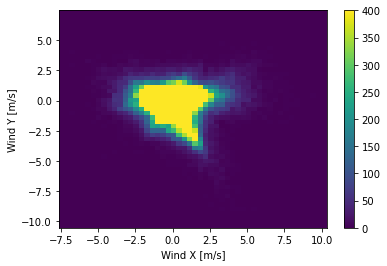

In [30]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

## Month and day as sine & cosine

In [31]:
datetimes = df.index.get_level_values(1)
datetimes = datetimes.map(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
timestamp_s = datetimes.map(datetime.datetime.timestamp)

day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

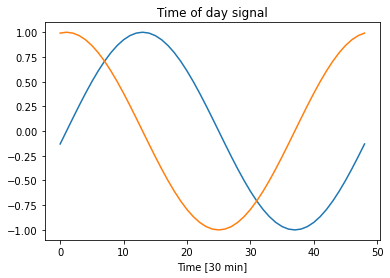

In [32]:
plt.plot(np.array(df['Day sin'])[:49])
plt.plot(np.array(df['Day cos'])[:49])
plt.xlabel('Time [30 min]')
plt.title('Time of day signal')

In [33]:
df.to_csv(interim_data_dir/'sbg-weather.csv', sep=';', encoding='utf8')

# Visual Exploration

In [27]:
df = pd.read_csv(interim_data_dir/'sbg-weather.csv', sep=';', encoding='utf8')

# parse date column & set multiindex
df.Zeitpunkt = pd.to_datetime(df.Zeitpunkt, format='%Y-%m-%d %H:%M:%S')
df.set_index(['Messort', 'Zeitpunkt'], inplace=True)

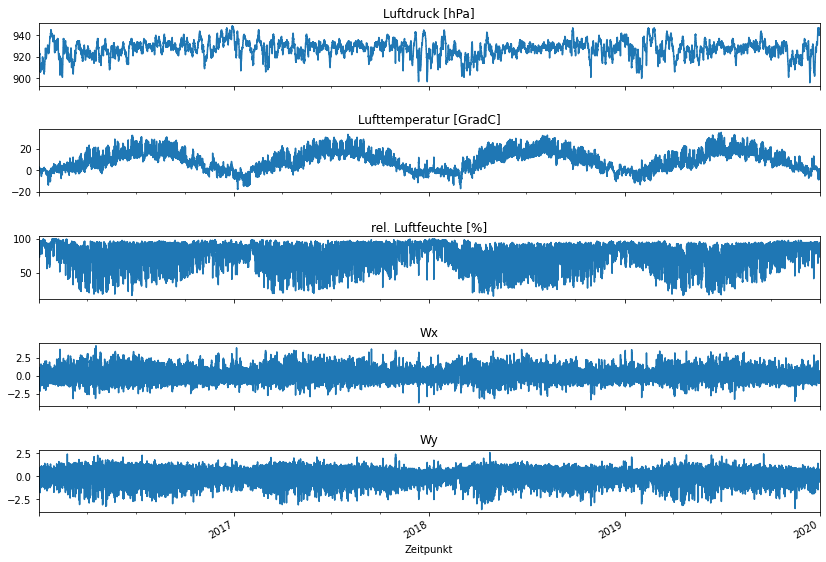

In [33]:
slc = slice('2016', None)
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy']

plot_metrics(df.loc['Zell am See - Eishalle'], metrics=metrics, selected_slice=slc)

In [32]:
df.index.get_level_values(0).unique()

Index(['Hallein Winterstall', 'Salzburg Lehener Park',
       'St.Johann - Bezirkshauptmannschaft', 'Zell am See - Eishalle'],
      dtype='object', name='Messort')

# Train test split

In [4]:
df = pd.read_csv(interim_data_dir/'sbg-weather.csv', sep=';', encoding='utf8')

# parse date column & set multiindex
df.Zeitpunkt = pd.to_datetime(df.Zeitpunkt, format='%Y-%m-%d %H:%M:%S')
df.set_index(['Messort', 'Zeitpunkt'], inplace=True)

In [6]:
# keep only hourly measures
# (instead of 30 min intervals)
df = df.iloc[1::2]

In [5]:
### encode locations as integers for embeddings
# get unique locations
locations_array = df.index.get_level_values(0)
unique_locations = locations_array.unique()
# assign an index to each location
locations_dict = {name: index for index, name in enumerate(unique_locations)}
locations_dict
# write assign index to corresponding location
assign_location_int = lambda x: locations_dict[x]
locations = list(map(assign_location_int, locations_array))


In [7]:
# set what ratio of the data should be used for
# training, validation & testing
train_share = .5
val_share = .25

In [8]:
d_range = pd.date_range('2016-01-01', '2019-12-31')
d_range = d_range.map(lambda x: datetime.datetime.strftime(x, '%Y-%m-%d'))
n_dates = len(d_range)

train_range = d_range[:int(n_dates*train_share)]
val_range = d_range[int(n_dates*train_share):int(n_dates*(train_share+val_share))]
test_range = d_range[int(n_dates*(train_share+val_share)):]

train_slice = slice(train_range[0], train_range[-1])
val_slice = slice(val_range[0], val_range[-1])
test_slice = slice(test_range[0], test_range[-1])

In [9]:
train_df_unscl = df.loc[pd.IndexSlice[:,train_slice],:].copy()
val_df_unscl = df.loc[pd.IndexSlice[:,val_slice],:].copy()
test_df_unscl = df.loc[pd.IndexSlice[:,test_slice],:].copy()

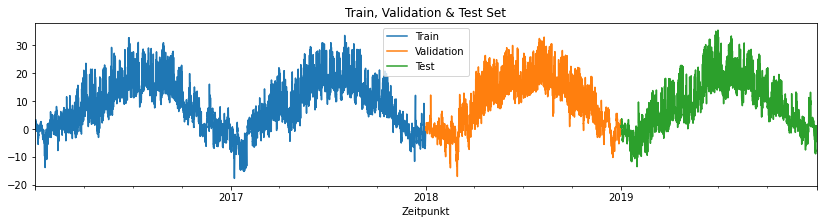

In [10]:
fig, ax = plt.subplots(figsize=(14,3))
d_range = pd.date_range('2016-01-01', '2019-12-31')

data = df.loc['Zell am See - Eishalle']
#data.index = pd.DatetimeIndex(data.index)

data.loc[train_slice, 'Lufttemperatur [GradC]'].plot(ax=ax, color='tab:blue', label='Train')
data.loc[val_slice, 'Lufttemperatur [GradC]'].plot(ax=ax, color='tab:orange', label='Validation')
data.loc[test_slice, 'Lufttemperatur [GradC]'].plot(ax=ax, color='tab:green', label='Test')
ax.legend()
ax.set_title('Train, Validation & Test Set')
plt.show()

# Scaling

In [11]:
scaler = StandardScaler()

train_matrix = scaler.fit_transform(train_df_unscl)
val_matrix = scaler.transform(val_df_unscl)
test_matrix = scaler.transform(test_df_unscl)

train_df = pd.DataFrame(train_matrix, columns=train_df_unscl.columns, index=train_df_unscl.index)
val_df = pd.DataFrame(val_matrix, columns=val_df_unscl.columns, index=val_df_unscl.index)
test_df = pd.DataFrame(test_matrix, columns=test_df_unscl.columns, index=test_df_unscl.index)

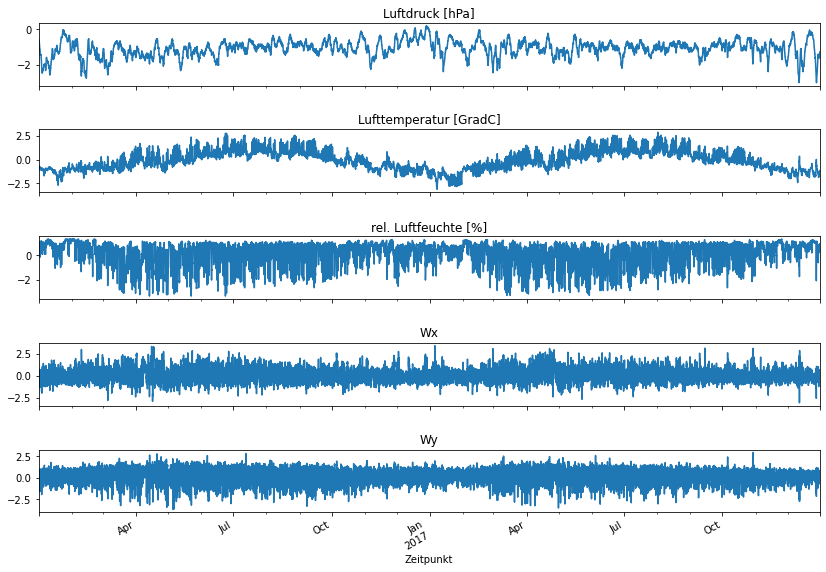

In [12]:
slc = slice('2016', None)
metrics = ['Luftdruck [hPa]', 'Lufttemperatur [GradC]', 'rel. Luftfeuchte [%]',
       'Wx', 'Wy']

plot_metrics(train_df.loc['Zell am See - Eishalle'], metrics=metrics, selected_slice=slc)

In [13]:
train_df.shape

(70076, 12)

In [14]:
# TODO:
# fix integer representation of locations
# modelling

In [22]:
from src.helpers import WindowGenerator

In [23]:
w1 = WindowGenerator(input_width=24, label_width=6, shift=6,
                     train_df=train_df, val_df=val_df, test_df=test_df,
                     label_columns=['Lufttemperatur [GradC]'],
                     embedding_column='Location')
w1

Total window size: 30
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29]
Label column name(s): ['Lufttemperatur [GradC]']

In [24]:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])

print(f'Window shape: {example_window.shape}')

Window shape: (3, 30, 12)


In [25]:
example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs[0].shape}')
print(f'Embedding-Inputs shape: {example_inputs[1].shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 30, 12)
Inputs shape: (3, 24, 11)
Embedding-Inputs shape: (3, 24)
labels shape: (3, 6, 1)


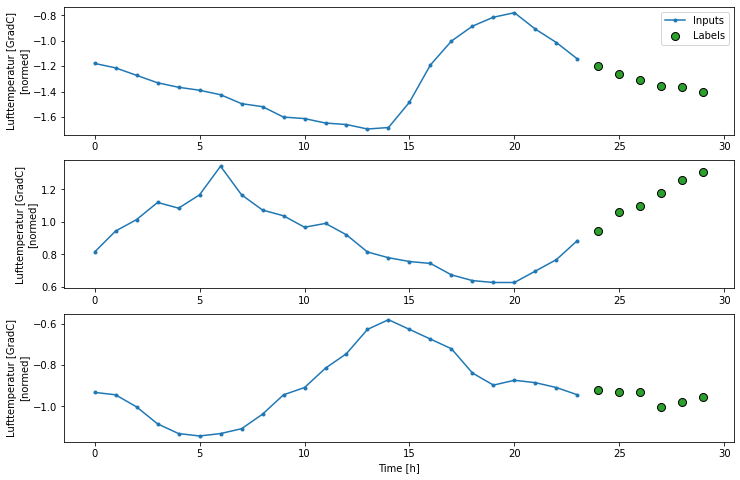

In [26]:
w1.plot()

In [27]:
w1.train

<MapDataset shapes: (((None, 24, 11), (None, 24)), (None, 6, 1)), types: ((tf.float32, tf.float32), tf.float32)>

In [30]:
tf.keras.backend.clear_session()

# Node Embeddings
embedding_inputs = tf.keras.Input(shape =(24,))
embedding_layer = tf.keras.layers.Embedding(input_dim=max(train_df.Location) + 1, 
                                            output_dim=2, input_length=24)(embedding_inputs)

# Encoder Inputs
feature_inputs = tf.keras.layers.Input(shape=(24, 11))

# Concat Embeddings & Encoder Inputs
concat_layer = tf.keras.layers.Concatenate()([feature_inputs, embedding_layer])

layer1 = tf.keras.layers.LSTM(30, return_sequences=True)(concat_layer)

output = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(units=6, activation='linear'))

output = output(layer1)

model = tf.keras.Model(inputs=[feature_inputs, embedding_inputs], outputs=output)

TypeError: Dimension value must be integer or None or have an __index__ method, got value '2.341640786499874' with type '<class 'float'>'